In [3]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import warnings
warnings.filterwarnings(action="ignore")
from zipfile import ZipFile
sns.set_style("darkgrid")
sns.set_palette(palette=["gray", "red", "green"])
import random
import re
import pickle


In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
df = pd.read_csv("Reviews.csv")
# df = df.select("Score", "Text")
df = df[["Score", "Text"]]
df = df.iloc[:10000, :]
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [6]:
df.shape

(10000, 2)

In [7]:
def clean_text(text):
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\S*@\S*\s?', '', text)

    return text.strip()

In [8]:
df["clean_text"] = df["Text"].apply(clean_text)

In [9]:
def get_sentiment(score): 
    if score > 3:
        return "Positive"
    elif score < 3:
        return "Negative"
    else:
        return "Neutral"

In [10]:
df['length'] = df['clean_text'].apply(lambda x: len(str(x).split()))
df['sentiment'] = df['Score'].apply(get_sentiment)
df.head()

,Score,Text,clean_text,length,sentiment
0,5,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...,48,Positive
1,1,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled as Jumbo Salted Peanut...,31,Negative
2,4,This is a confection that has been around a fe...,This is a confection that has been around a fe...,94,Positive
3,2,If you are looking for the secret ingredient i...,If you are looking for the secret ingredient i...,41,Negative
4,5,Great taffy at a great price. There was a wid...,Great taffy at a great price. There was a wid...,27,Positive


## Distribution of sentiment categories

In [11]:
sentiment_counts = df.groupby("sentiment").count()
sentiment_counts.head()

,Score,Text,clean_text,length
sentiment,,,,
Negative,1522,1522,1522,1522
Neutral,862,862,862,862
Positive,7616,7616,7616,7616


In [12]:
# sentiment_counts = df.groupby("sentiment").count()

# fig, ax = plt.subplots()
# ax.pie(
#     # x=sentiment_counts["count"], 
#     labels=sentiment_counts["sentiment"],
#     autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts["count"])/100)})', 
#     wedgeprops=dict(width=0.7),
#     textprops = dict(size=10),
#     pctdistance = 0.7)

# center_circle = plt.Circle((0, 0), 0.1, color='black', fc='white', linewidth=1.25)
# fig.gca().add_artist(center_circle)
# ax.set_title("Distribution of sentiment labels", weight="bold")
# plt.show()


### The dataset is highly imbalanced so downsampling the majority class

In [13]:
neu_df = df[df["sentiment"] == "Neutral"]
neg_df = df[df["sentiment"] == "Negative"]
pos_df = df[df["sentiment"] == "Positive"]

pos_df = pos_df.sample(len(neg_df))

df2 = pd.concat([neg_df, neu_df, pos_df], axis=0)

In [14]:
#To clear RAM due to the size of the dataset.
del neu_df, neg_df, pos_df, df  

### Distribution of sentences length

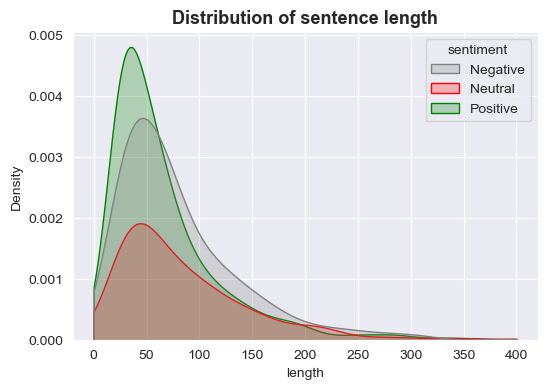

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(data=df2, x="length", shade=True, hue="sentiment", clip=[0, 400], ax=ax)
ax.set_title("Distribution of sentence length", size=13, weight="bold")
plt.show()


In [16]:
target = df2["sentiment"]
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

### Splitting the data to Training, Testing & Validation set

In [17]:
def split_data(X, y = None, *, train_ratio=0.7, test_ratio=0.15, validation_ratio=0.15, seed=None):
    if train_ratio + test_ratio + validation_ratio != 1.0:
        raise ValueError("Ratios should add up to 1.0")

    total_length = len(X)
    train_size = int(train_ratio * total_length)
    test_size = int(test_ratio * total_length)

    if seed is not None:
        np.random.seed(seed)
    index = np.random.permutation(np.arange(total_length))
    X = np.array(X)[index]

    train_X = X[:train_size]
    test_X = X[train_size:train_size + test_size]
    validation_X = X[train_size + test_size:]

    if y is not None:
        y = y[index]
        train_y = y[:train_size]
        test_y = y[train_size:train_size + test_size]
        validation_y = y[train_size + test_size:]

        return (train_X, train_y), (test_X, test_y), (validation_X, validation_y)
    return train_X, test_X, validation_X

In [18]:
train_data, test_data, validation_data = split_data(
    df2["clean_text"],
    target,
    train_ratio=0.7,
    test_ratio=0.15,
    validation_ratio=0.15,
    seed=42)

### Vectorizing and preparing Tensorflow Datasets.


- max_tokens: Limits vocabulary size to 40,000 tokens for memory efficiency.
- seq_len: Sets max sequence length for input sequences to 150 tokens.
- batch_size: Specifies 64 samples processed in each training iteration.

In [19]:
max_tokens = 40000
seq_len = 200
batch_size = 64

feature_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=seq_len,
    encoding='utf-8',)

feature_vectorizer.adapt(train_data[0])

In [20]:
X_train = feature_vectorizer(train_data[0])
X_test = feature_vectorizer(test_data[0])
X_valid = feature_vectorizer(validation_data[0])

y_train = train_data[1]
y_test = test_data[1]
y_valid = validation_data[1]

In [21]:
del train_data, target, validation_data

In [22]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

train_ds = train_ds.shuffle(5000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(5000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(5000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [23]:
for inputs, target in train_ds.take(1).as_numpy_iterator():
    for i in range(2):
        print(tf.shape(inputs[i]))
        print()
        print("Inputs:", inputs[i, :20])
        print("Target:", target[i])

tf.Tensor([200], shape=(1,), dtype=int32)

Inputs: [ 127   16  436  277 4427  381    2  554    4 4357   38  165    5   88
    6  266  130   90   73   23]
Target: 0
tf.Tensor([200], shape=(1,), dtype=int32)

Inputs: [  80  966    6   29  637   11  637    4  109   81  637   47  378    2
  860   24  660 1280   38  192]
Target: 2


## The Transformer Encoder Block


In [24]:
class TransformerBlock(layers.Layer):
    def __init__(self, emb_dim, num_heads, ff_dim, dropout, **kwargs):
        super().__init__(**kwargs)
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.attention = layers.MultiHeadAttention(self.num_heads, self.emb_dim,)
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.fc = layers.Dense(self.ff_dim, activation="relu")
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        att_outputs = self.attention(inputs, inputs)
        att_outputs = self.dropout(att_outputs)
        x = self.layer_norm1(inputs+att_outputs)
        fc_output = self.fc(x)
        return self.layer_norm2(x + fc_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embedding_dim": self.emb_dim,
            "num_heads": self.num_heads,
            "hidden_dim": self.ff_dim
        })
        return config

In [25]:
class TokenAndPositionalEmbedding(layers.Layer):
    def __init__(self, emb_dim, seq_len, **kwargs):
        super().__init__(**kwargs)
        self.emb_dim = emb_dim
        self.vectorizer = feature_vectorizer
        self.seq_len = seq_len
        self.vocab_size = self.vectorizer.vocabulary_size()
        self.token_embeddings = layers.Embedding(self.vocab_size, self.emb_dim, mask_zero=True)
        self.pos_embeddings = layers.Embedding(self.seq_len, self.emb_dim)

    def call(self, inputs):
        x = self.token_embeddings(inputs)
        positions = tf.range(0, self.seq_len)
        pos_emb = self.pos_embeddings(positions)
        return x + pos_emb

In [26]:
class SentimentModel(Model):

    @classmethod
    def add_method(cls, func):
        setattr(cls, func.__name__, func)
        return func

    def __init__(self, emb_dim, num_heads, ff_dim, seq_len, dropout, output_shape, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.embeddings = TokenAndPositionalEmbedding(emb_dim, seq_len)
        self.encoder = TransformerBlock(emb_dim, num_heads, ff_dim, dropout, name="transform-block")
        self.pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout)
        self.fc = layers.Dense(output_shape, activation="softmax")

    def call(self, inputs):
        x = self.embeddings(inputs)
        x = self.encoder(x)
        x = self.pooling(x)
        x = self.dropout(x)
        outputs = self.fc(x)
        return outputs

In [27]:
emb_dim = 256
num_heads = 5
ff_dim = 256
dropout = 0.50
output_shape = 3

model = SentimentModel(emb_dim, num_heads, ff_dim, seq_len, dropout, output_shape)
model.build(input_shape=(None, seq_len))
model.summary()



Model: "sentiment_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_positional_embed  multiple                  3290368   
 ding (TokenAndPositionalEm                                      
 bedding)                                                        
                                                                 
 transform-block (Transform  multiple                  1381632   
 erBlock)                                                        
                                                                 
 global_average_pooling1d (  multiple                  0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple            

In [28]:
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

In [29]:
epochs = 10
early_stopping = EarlyStopping(patience=3, min_delta=1e-2, monitor="val_loss", restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs = epochs,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/10


42/42 [==============================] - 24s 501ms/step - loss: 1.4310 - acc: 0.3731 - val_loss: 1.0486 - val_acc: 0.4549
Epoch 2/10
42/42 [==============================] - 25s 590ms/step - loss: 1.0747 - acc: 0.4334 - val_loss: 0.9858 - val_acc: 0.5486
Epoch 3/10
42/42 [==============================] - 26s 604ms/step - loss: 0.8429 - acc: 0.6101 - val_loss: 0.8880 - val_acc: 0.6059
Epoch 4/10
42/42 [==============================] - 20s 482ms/step - loss: 0.4488 - acc: 0.8248 - val_loss: 0.7961 - val_acc: 0.6806
Epoch 5/10
42/42 [==============================] - 21s 496ms/step - loss: 0.1567 - acc: 0.9461 - val_loss: 1.1508 - val_acc: 0.6771
Epoch 6/10
42/42 [==============================] - 21s 509ms/step - loss: 0.0529 - acc: 0.9825 - val_loss: 1.7689 - val_acc: 0.6701
Epoch 7/10
42/42 [==============================] - 20s 488ms/step - loss: 0.0236 - acc: 0.9926 - val_loss: 1.8975 - val_acc: 0.6545


### Qualitative Evaluation

In [30]:
@model.add_method
def classify_sentence(self, sentence):
    tokens = self.embeddings.vectorizer(sentence)
    tokens = tf.expand_dims(tokens, 0)
    proba = self(tokens)
    preds = tf.argmax(proba, axis = 1).numpy()
    return {
        "Predicted": label_encoder.inverse_transform(preds)[0],
        "Probability": np.squeeze(proba.numpy())[preds[0]]
    }

In [31]:
def predict_random():
    score = 0
    x_test, y_test = test_data
    indexes = np.random.choice(len(x_test), 10)
    for i in indexes:
        pred_dict = model.classify_sentence(x_test[i])
        pred_dict["Actual"] = label_encoder.inverse_transform(y_test[[i]])[0]
        score += pred_dict["Predicted"] == pred_dict["Actual"]
        print(pred_dict)
    print(f"\nTotal Accuracy: {(score/10):.2%}")

In [32]:
predict_random()

{'Predicted': 'Negative', 'Probability': 0.9983606, 'Actual': 'Negative'}
{'Predicted': 'Neutral', 'Probability': 0.98741174, 'Actual': 'Negative'}
{'Predicted': 'Positive', 'Probability': 0.62749255, 'Actual': 'Negative'}
{'Predicted': 'Neutral', 'Probability': 0.916243, 'Actual': 'Neutral'}
{'Predicted': 'Neutral', 'Probability': 0.83632725, 'Actual': 'Neutral'}
{'Predicted': 'Positive', 'Probability': 0.9775098, 'Actual': 'Positive'}
{'Predicted': 'Positive', 'Probability': 0.5448961, 'Actual': 'Positive'}
{'Predicted': 'Positive', 'Probability': 0.6595642, 'Actual': 'Positive'}
{'Predicted': 'Positive', 'Probability': 0.88413477, 'Actual': 'Neutral'}
{'Predicted': 'Negative', 'Probability': 0.95396346, 'Actual': 'Negative'}

Total Accuracy: 70.00%


### Quantitative Evaluation

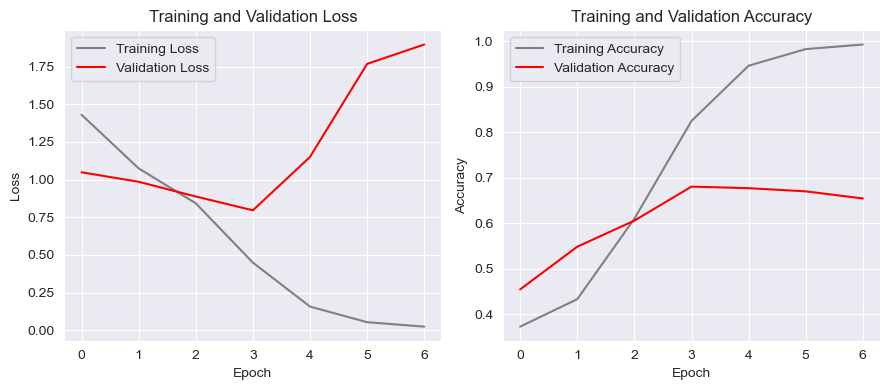

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['acc'], label='Training Accuracy')
axes[1].plot(history.history['val_acc'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [34]:
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

9/9 [==============================] - 1s 161ms/step - loss: 0.8736 - acc: 0.6545


[0.8736371994018555, 0.6545138955116272]

In [35]:
# Exporting the model as a .pkl file
filename = "model.pkl"
pickle.dump(model, open(filename, 'wb'))